# Generate model response to visual stimuli

this notebook plots trained stcnn model calcium responses to a variety of visual stimuli

- dataloader contains groundtruth calcium recordings and visual stimuli movie
- model can generate calcium predictions for any movie in the dataloader


In [1]:
import sys
sys.path.append('..')

import os
import torch
import torch.nn.functional as F
import numpy as np
import math

from stcnn.ca_dataloader import LCDataLoader, load_ca_data, load_vstim_mov
from stcnn.model_factory import model_stcnn_factory
from stcnn.util_analysis import get_data_by_vstim, plot_traces_in_grid, get_one_vstim_mov 

import pickle

from pathlib import Path
import matplotlib.pyplot as plt

from celluloid import Camera

from natsort import natsorted

import json

In [2]:
if torch.cuda.is_available():
    print(torch.cuda.get_device_name())
    dev_cnt = torch.cuda.device_count()
    print(f'CUDA version {torch.version.cuda}')
    my_device = torch.device('cuda:' + str(dev_cnt-1) )  
else:
    my_device = torch.device('cpu')

print(my_device)

Quadro RTX 5000
CUDA version 10.2
cuda:1


## Define file paths for model config and checkpoints

user has to select a model checkpoint to load, default is the last checkpoint  
available checkpoint files are listed below

In [3]:
cwd_path = Path.cwd()

# setup path containing model training checkpoints
base_path = cwd_path.parent
expt_dir = 'experiments'
trained_model_dir = 'lc_small_3'

model_dir = base_path / expt_dir / trained_model_dir
fname_prefix = 'model_chkpnt_'
fname_suffix = '.pt'

# search for checkpoint files
chkpnt_fnames = [str(f.name) for f in os.scandir(model_dir) if f.name.startswith(fname_prefix) and f.name.endswith(fname_suffix) and f.is_file()]
chkpnt_fnames = natsorted(chkpnt_fnames)

chkpnt_fnames

['model_chkpnt_0.pt',
 'model_chkpnt_1.pt',
 'model_chkpnt_2.pt',
 'model_chkpnt_3.pt',
 'model_chkpnt_4.pt',
 'model_chkpnt_5.pt',
 'model_chkpnt_6.pt',
 'model_chkpnt_7.pt',
 'model_chkpnt_8.pt',
 'model_chkpnt_9.pt',
 'model_chkpnt_10.pt']

In [4]:
# load one checkpoint
sel_chkpnt = chkpnt_fnames[-1]
checkpoint = torch.load( model_dir / sel_chkpnt, map_location=my_device)

print(f'load model from {sel_chkpnt}')

load model from model_chkpnt_10.pt


In [5]:
# load model configuration
model_config = 'config.json'
with open( model_dir / model_config) as f:
    config = json.load(f)

In [6]:
# setup path for saving analysis
output_dir = model_dir / 'analysis'
Path(output_dir).mkdir(parents=True, exist_ok=True)

## setup dataloader

by default loads data from paths specified during training.  
should change ca_path and mov_path if data is in different dir

In [7]:
ca_path = config['dataset_config']['ca_path']
mov_path = config['dataset_config']['mov_path']

# other dataloader options
sampling_rate = config['dataset_config']['sampling_rate']
avg_xTrials = True
num_t_pts_prepad = config['dataset_config']['num_t_pts_prepad']

In [8]:
ca_traces, num_t_pts = load_ca_data(input_path=ca_path, my_device=torch.device("cpu"))
vstim_mov = load_vstim_mov(mov_path, my_device=torch.device("cpu"))

dataset = LCDataLoader(
    vstim_mov,
    ca_traces,
    num_t_pts,
    avg_xTrials=avg_xTrials,
    my_device=my_device,
    px_res=config['dataset_config']['mov_res'],
    mov_bg_int=config['dataset_config']['mov_bg_int'],
    opts_meas_t_start=config['dataset_config']['loss_meas_t_start'],
    num_t_pts_prepad=num_t_pts_prepad,
)

## load model and checkpoint

In [9]:
model = model_stcnn_factory(config['pr_config'],
                            config['network_config'], 
                            config['L_config'], 
                            config['ca_config'],
                            config['sampling_rate'],
                            my_device)

In [10]:
model.load_state_dict( checkpoint['model'], strict=False )

<All keys matched successfully>

In [11]:
model.to(my_device)

model.eval() # switch to evaulation mode, applies to layers like batchnorm (to not update running average)

LCModelBatchnorm(
  (ca_param): ModuleDict(
    (lc11): ParameterDict(
        (alpha): Parameter containing: [torch.cuda.FloatTensor of size 10 (GPU 1)]
        (beta): Parameter containing: [torch.cuda.FloatTensor of size 10 (GPU 1)]
        (ca_tau): Parameter containing: [torch.cuda.FloatTensor of size 1 (GPU 1)]
    )
    (lc18): ParameterDict(
        (alpha): Parameter containing: [torch.cuda.FloatTensor of size 19 (GPU 1)]
        (beta): Parameter containing: [torch.cuda.FloatTensor of size 19 (GPU 1)]
        (ca_tau): Parameter containing: [torch.cuda.FloatTensor of size 1 (GPU 1)]
    )
    (lc17): ParameterDict(
        (alpha): Parameter containing: [torch.cuda.FloatTensor of size 20 (GPU 1)]
        (beta): Parameter containing: [torch.cuda.FloatTensor of size 20 (GPU 1)]
        (ca_tau): Parameter containing: [torch.cuda.FloatTensor of size 1 (GPU 1)]
    )
    (lc12): ParameterDict(
        (alpha): Parameter containing: [torch.cuda.FloatTensor of size 10 (GPU 1)]
   

## Generate calcium predictions to user specified stimuli

- will generate calcium response for every trained celltype in the model
- can generate modeled responses to user specified visual stimuli (as protocol #) 
- auto plot groundtruth calcium data along with prediction if it's available


In [12]:
# define grouth truth ca trace color
ca_true_color = "#ffcfa1"

### Size tuning example

In [13]:
out_file_suffix = '_size_tuning'

In [14]:
# define protocol numbers
prot_a = 5619
prot_b = 5667

prot_list = np.arange(prot_a, prot_b+1)
prot_list

array([5619, 5620, 5621, 5622, 5623, 5624, 5625, 5626, 5627, 5628, 5629,
       5630, 5631, 5632, 5633, 5634, 5635, 5636, 5637, 5638, 5639, 5640,
       5641, 5642, 5643, 5644, 5645, 5646, 5647, 5648, 5649, 5650, 5651,
       5652, 5653, 5654, 5655, 5656, 5657, 5658, 5659, 5660, 5661, 5662,
       5663, 5664, 5665, 5666, 5667])

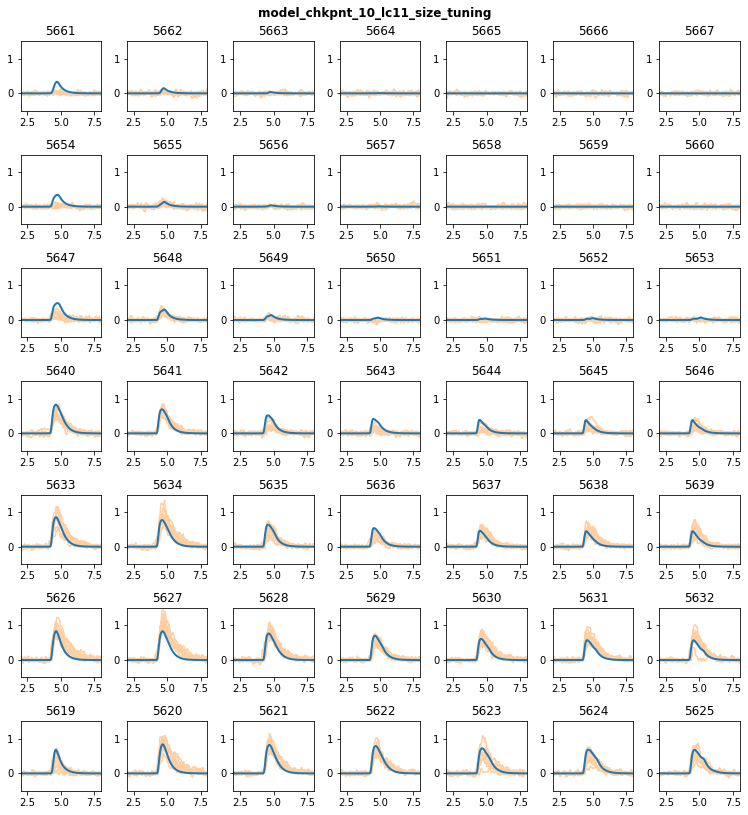

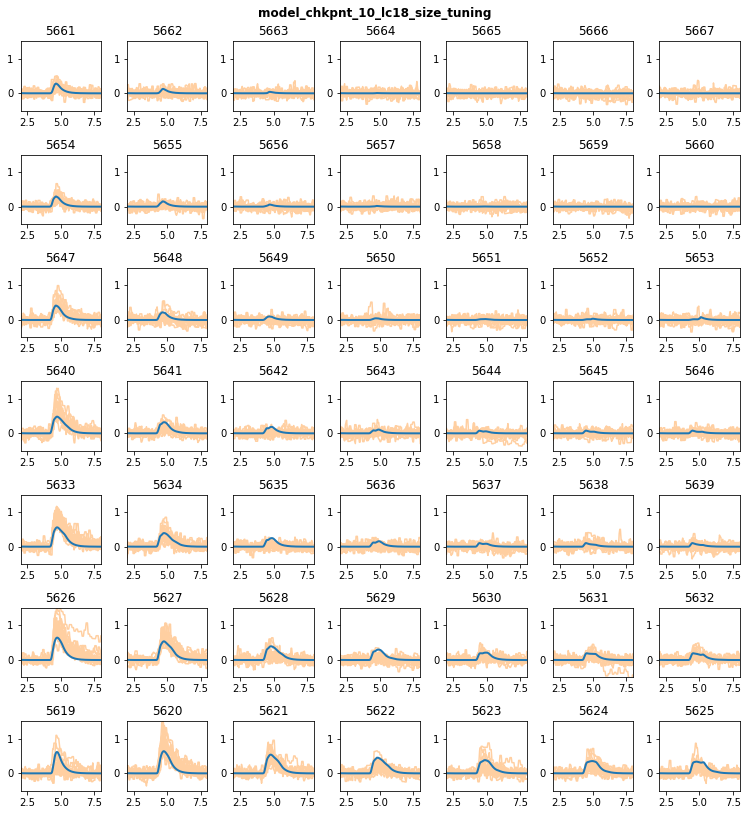

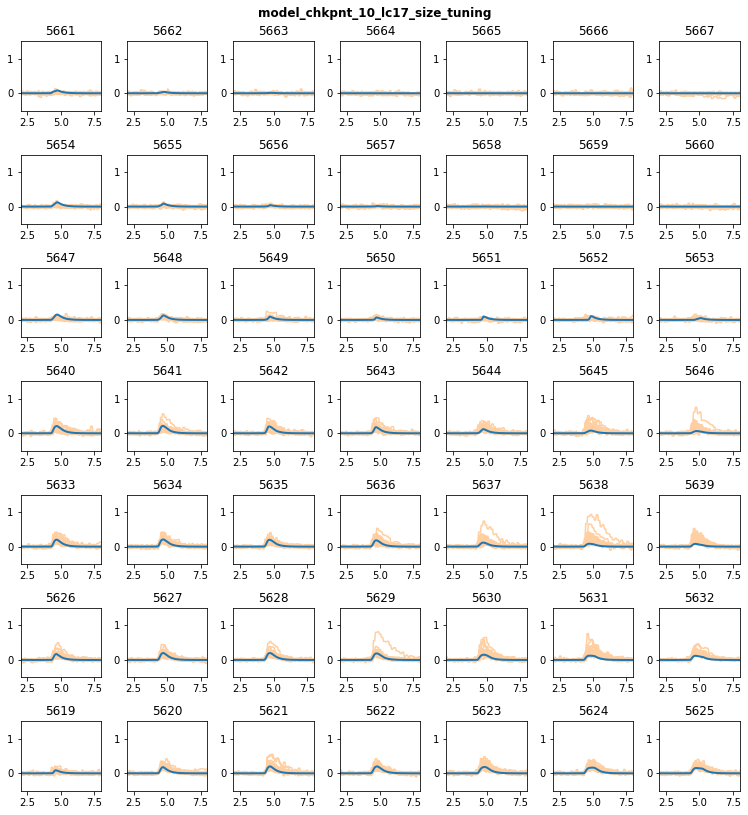

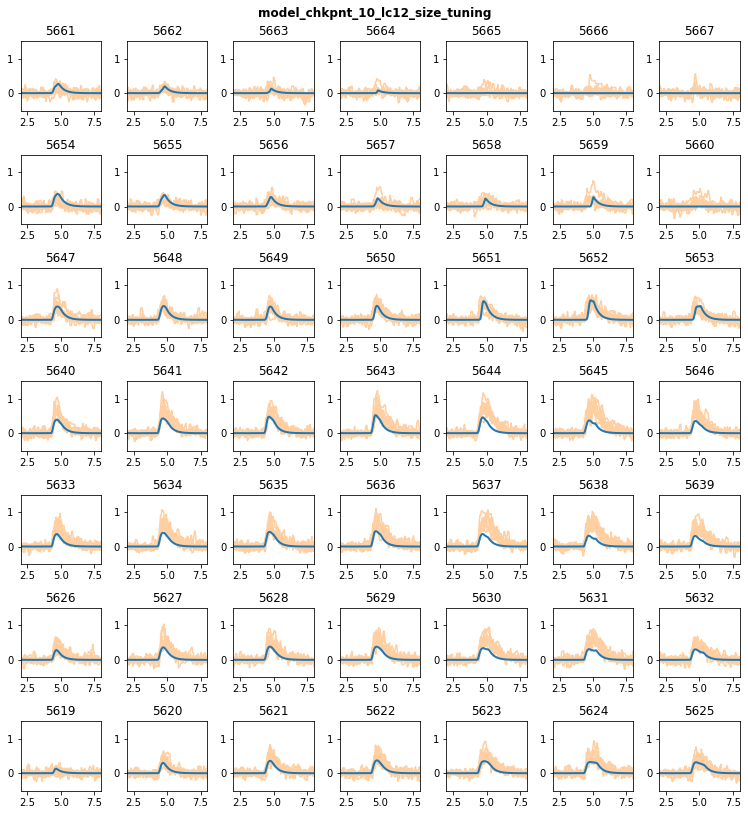

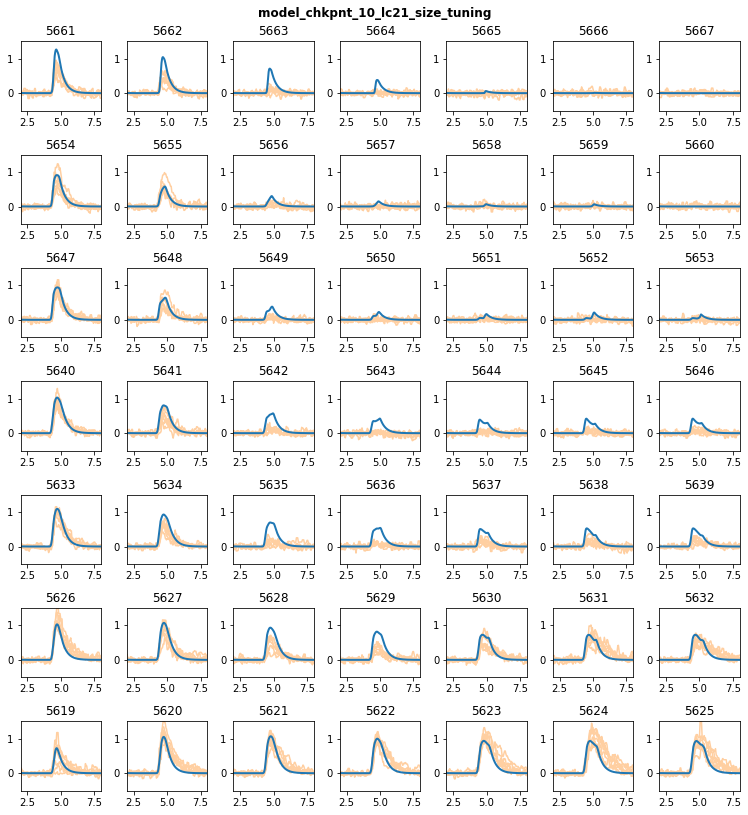

In [15]:
for lc in config['data_count'].keys():
    title_fname = sel_chkpnt[:-3] + '_' + lc + out_file_suffix
    plot_traces_in_grid(dataset,
                        model,
                        prot_list,
                        lc, 
                        suptitle=title_fname, 
                        out_path=output_dir, 
                        show_title=True,
                        ca_true_color=ca_true_color)

### Looming responses example

In [16]:
out_file_suffix = '_looming'

In [17]:
# define protocol numbers
prot_a = 321
prot_b = 329

prot_list = np.arange(prot_a, prot_b+1)
prot_list

array([321, 322, 323, 324, 325, 326, 327, 328, 329])

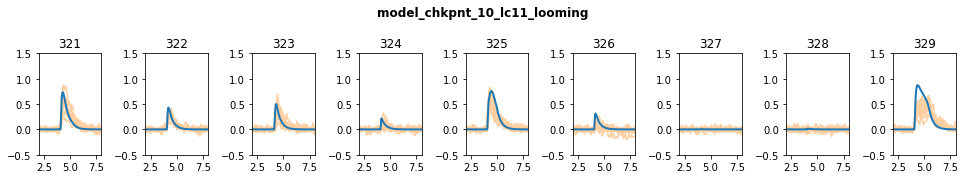

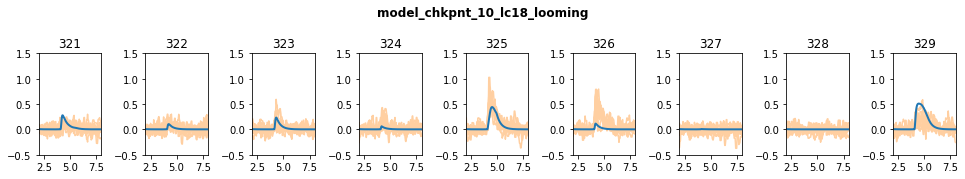

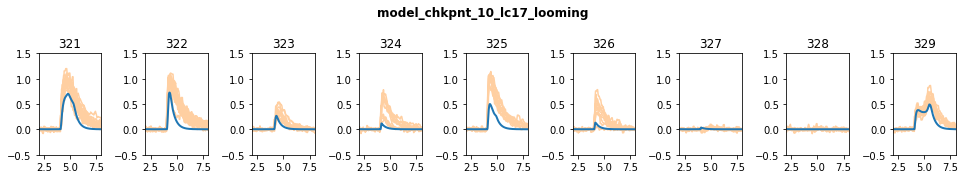

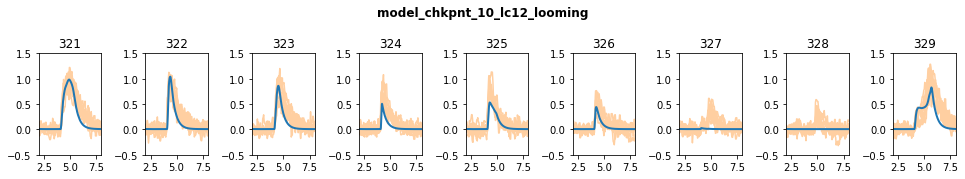

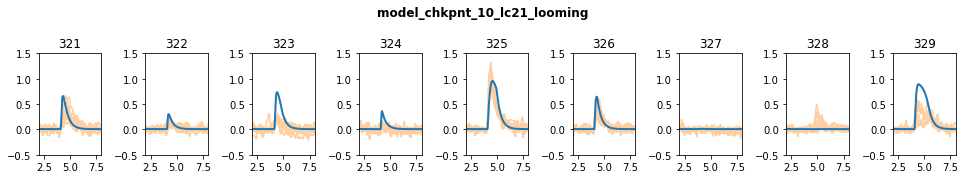

In [18]:
for lc in config['data_count'].keys():
    title_fname = sel_chkpnt[:-3] + '_' + lc + out_file_suffix
    plot_traces_in_grid(dataset,
                        model,
                        prot_list,
                        lc,
                        suptitle=title_fname,
                        num_rows=1, 
                        num_cols=len(prot_list), 
                        rev_row=False, 
                        show_title=True, 
                        out_path=output_dir,
                        ca_true_color=ca_true_color,)